# Model plots
Created 26/11/2020 
Refactored fom `plots.ipynb` 

In [3]:
#matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import models 
import importlib
import indexTools
import pymc3 as pm
import bee_util as bu
importlib.reload(models)
importlib.reload(bu)
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
from glob import glob
import os
files=sorted(glob("results_analyse/cont_*.csv"))+\
    sorted(glob('results_analyse/caged*.csv'))+\
    sorted(glob('results_analyse/banked*.csv'))

import data_handling as dh
df = dh.read_data(files)

# add integer labels for the various groupings 
df['i_ind'],     df['ucode']   = indexTools.multilabel_encoder(df,'treat day rep string'.split())
df['i_treatday'],df['treatday']= indexTools.multilabel_encoder(df,'treat day'.split())
df['i_treat'],_                = indexTools.multilabel_encoder(df,'treat'.split())

In [5]:
# read in the traces
fit_o = models.oocyte_model(df)
trace_o = pm.load_trace("/Volumes/scratch/sarah/traces/trace_oc_p1",fit_o)

In [6]:
fit_n = models.nurse_model(df)
trace_n = pm.load_trace("/Volumes/scratch/sarah/traces/trace_ns_p1",fit_n)

## plots from the trace

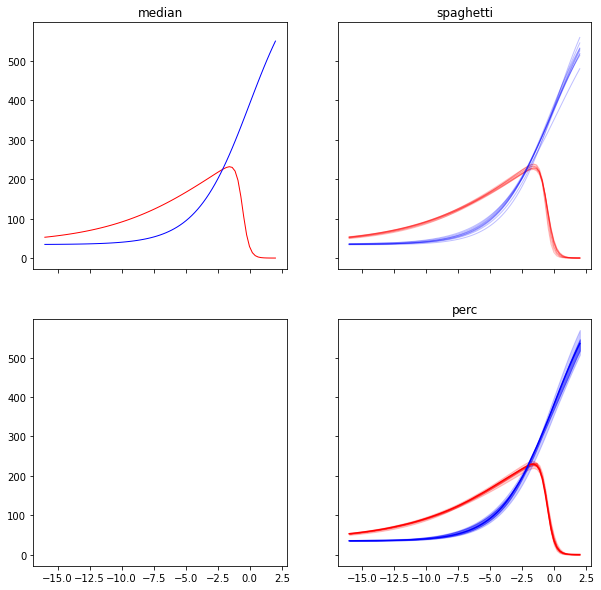

In [76]:
fig,axs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))
i_ind = 10
ax = axs[0,0]
ax.set_title("median")
bu.posterior_comp_r(ax,df,trace_n,i_ind,code='n',ptype='median',color='red',index='i_ind',nsamp=10,alpha=1,lw=1)
bu.posterior_comp_r(ax,df,trace_o,i_ind,code='o',ptype='median',color='blue',index='i_ind',nsamp=10,alpha=1,lw=1)

ax = axs[0,1]
ax.set_title("spaghetti")
bu.posterior_comp_r(ax,df,trace_n,i_ind,code='n',ptype='spag',color='red',index='i_ind',nsamp=10,alpha=0.25,lw=0.1)
bu.posterior_comp_r(ax,df,trace_o,i_ind,code='o',ptype='spag',color='blue',index='i_ind',nsamp=10,alpha=0.25,lw=0.1,samp=10)

ax = axs[1,1]
ax.set_title("perc")
bu.posterior_comp_r(ax,df,trace_n,i_ind,code='n',ptype='perc',color='red',index='i_ind',nsamp=10,alpha=0.25,lw=0.1)
bu.posterior_comp_r(ax,df,trace_o,i_ind,code='o',ptype='perc',color='blue',index='i_ind',nsamp=10,alpha=0.25,lw=0.1,samp=10)

## single exp unit plot

In [6]:
def plot_exp_unit( ax, df, iexp, alpha=1):
    mask = df['i_ind']==iexp
    dft = df[mask]
    x = dft['pos'].values
    yo = dft['Oc_size'].values
    yn = dft['Ns_size'].values   
    xp = np.linspace(0,max(x)+2,40)
    ax.plot(-x,yo,'-',label='oocyte',color='red',alpha=alpha)
    ax.plot(-x,yn,'-',label='nurse',color='blue',alpha=alpha)
    ax.plot(-x,yo-yn,'-',label='diff',color='green',alpha=alpha)
    ax.set_xticklabels( [-int(x) for x in ax.get_xticks()])

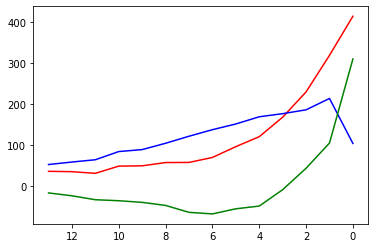

In [26]:
fig,ax = plt.subplots(1,1)
plot_exp_unit(ax,df,5)

## Multi-panel comparision 

In [34]:
# set the plot dictionary that contains the treatments, days and replicates
treatdays = df['treatday'].unique() 
pdict=dict.fromkeys(treatdays,None)
for td in treatdays:
    mask_td = df['treatday']==td
    reps = (df.loc[mask_td,'rep'].unique())
    pdict[td]=dict.fromkeys(reps,None)
    for rep in reps:
        #plot_exp_unit( ax, df, iexp, alpha=1)
        mask_r = df.loc[mask_td,'rep']==rep
        strings = df.loc[mask_td&mask_r,'string' ].unique()
        pdict[td][rep]=strings.astype(int)

### Raw data

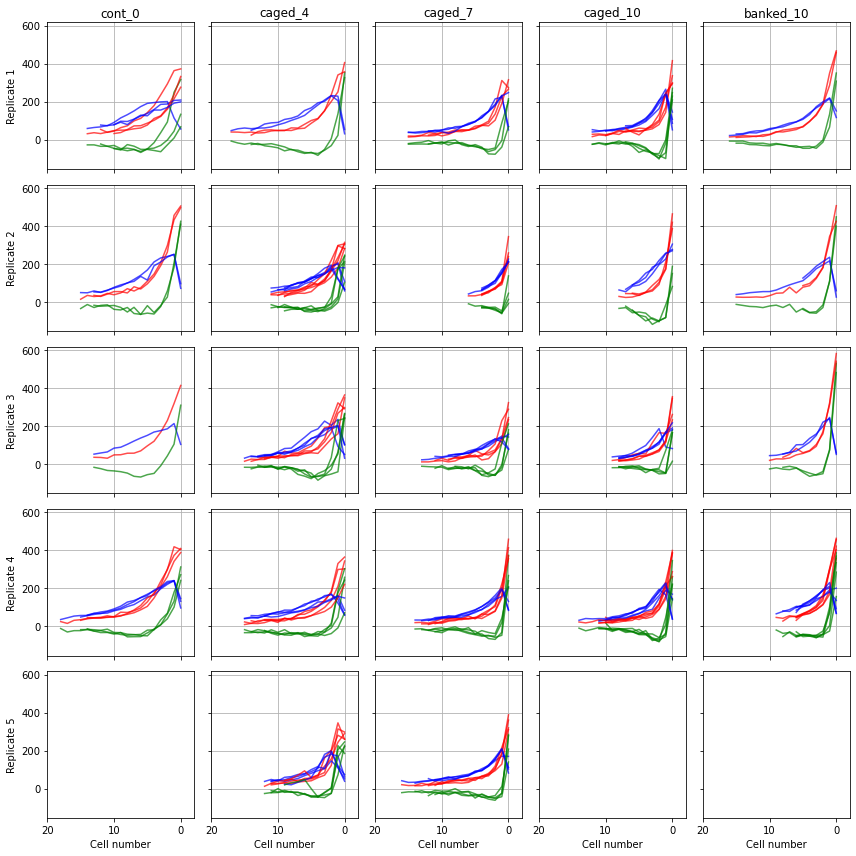

In [39]:
fig,axs = plt.subplots(5,5,sharex=True,sharey=True,figsize=(12,12))
for i,(treatday,exp) in enumerate(pdict.items()):
    #print(treatday)
    for j,(rep,strings) in enumerate(exp.items()):
        #print("   ",rep,strings)
        ax = axs[j,i]
        ax.set_xlim(-20,2)

        if( j==0 ): ax.set_title(treatday)
        
        for s in strings:
            mask = (df['treatday']==treatday)&(df['rep']==rep)&(df['string']==s)
            dft =df[mask]
            iexp = dft['i_ind'].values[0]
            plot_exp_unit( ax, df, iexp, alpha=0.7)
        ax.set_xticklabels( [-int(x) for x in ax.get_xticks()])
            #ax.plot(dft['pos'],dft['Oc_size'],color=blue)

        ax.set_xlim(-20,2)
        ax.grid()
for j in range(5):
    axs[j,0].set_ylabel("Replicate {}".format(j+1))
for i in range(5):
    axs[4,i].set_xlabel("Cell number")
fig.tight_layout()
#plt.savefig("raw_data_panel_comp.pdf")

### fitted

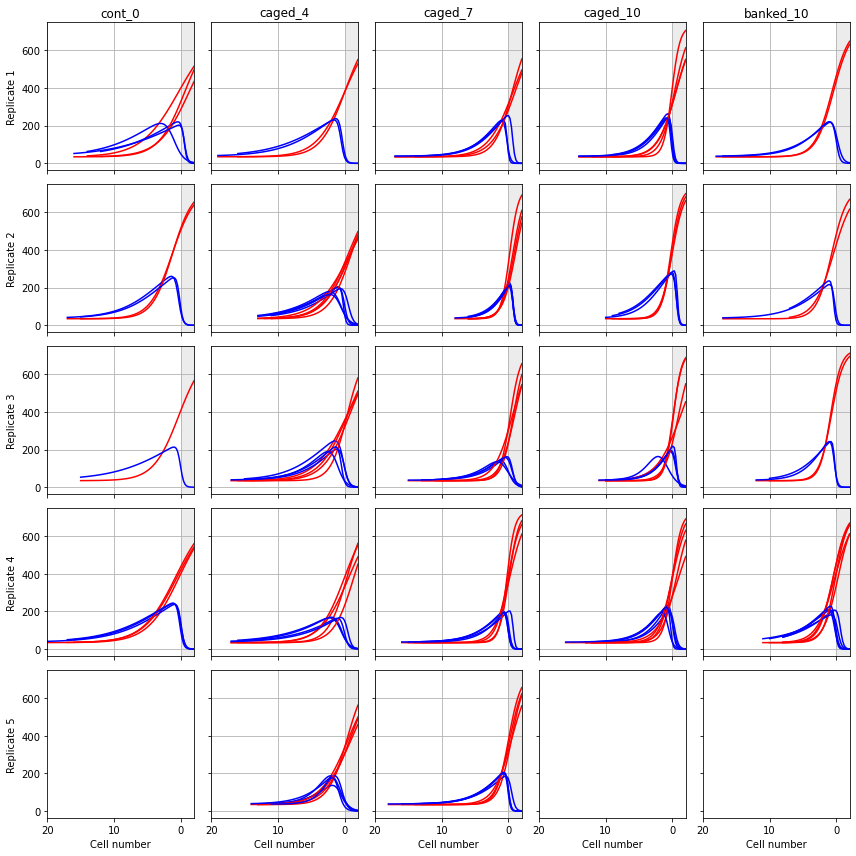

In [85]:
fig,axs = plt.subplots(5,5,sharex=True,sharey=True,figsize=(12,12))
for i,(treatday,exp) in enumerate(pdict.items()):
    #print(treatday)
    for j,(rep,strings) in enumerate(exp.items()):
        #print("   ",rep,strings)
        ax = axs[j,i]
        ax.set_xlim(-20,2)

        if( j==0 ): ax.set_title(treatday)
        
        for s in strings:
            mask = (df['treatday']==treatday)&(df['rep']==rep)&(df['string']==s)
            dft =df[mask]
            iexp = dft['i_ind'].values[0]
            #plot_exp_unit( ax, df, iexp, alpha=0.7)
            bu.posterior_comp_r(ax,df,trace_o,iexp,code='o',ptype='median',color='red')
            bu.posterior_comp_r(ax,df,trace_n,iexp,code='n',ptype='median',color='blue' )
        ax.set_xticklabels( [-int(x) for x in ax.get_xticks()])
            #ax.plot(dft['pos'],dft['Oc_size'],color=blue)

        ax.set_xlim(-20,2)
        ax.axvspan(0,2,color='grey',alpha=0.15)
        ax.grid()
for j in range(5):
    axs[j,0].set_ylabel("Replicate {}".format(j+1))
for i in range(5):
    axs[4,i].set_xlabel("Cell number")
fig.tight_layout()
#plt.savefig("fitted_data_panel_comp.pdf")

## Single row comparison

### fitted

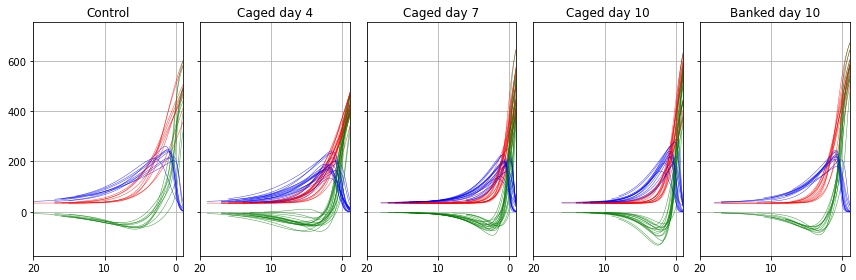

In [8]:
import matplotlib.lines as mlines

fig,axs = plt.subplots(1,5,sharex=True,sharey=True,figsize=(12,4))
colors ='blue green orange red grey'.split()
labels ="Control;Caged day 4;Caged day 7;Caged day 10;Banked day 10".split(';')

#lines_leg =[ mlines.Line2D([], [], color=colors[j], label=labels[j]) for j in range(5)]

i_inds = df['i_ind'].unique()
for i_ind in i_inds:
    i_treatday = df[df['i_ind']==i_ind]['i_treatday'].values[0]
    j = i_treatday
    ax = axs[j]
    #ax.set_title(labels[j])
    #ax.axhline(0,ls='--',lw=1.2,color='k')
    bu.posterior_comp_r(ax,df,trace_o,i_ind,code='o',ptype='median',color='red', index='i_ind',alpha=0.75,lw=0.5)
    x = ax.get_lines()[-1].get_xdata()
    yo = ax.get_lines()[-1].get_ydata()
    bu.posterior_comp_r(ax,df,trace_n,i_ind,code='n',ptype='median',color='blue',index='i_ind',alpha=0.75,lw=0.5)
    yn = ax.get_lines()[-1].get_ydata()
    ax.plot(x,yo-yn,color='green',alpha=0.75,lw=0.5)
axs[0].set_xlim(-20,1)
for ax,label in zip(axs,labels):
    ax.set_xticklabels( -int(x) for x in ax.get_xticks() )
    ax.set_title(label)
    ax.grid()
plt.tight_layout()
#plt.savefig('median_ind.pdf')